<h1 style="color: #3a75c4;">Heart Failure Prediction</h1>

<h2 style="color: #75aadb;">00 | Libraries</h2>

In [1]:
# 📚 Basic libraries
import pandas as pd
import numpy as np 

# 🤖 Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# File system libraries
import os
import sys
import pickle

# Add the root directory to sys.path 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Project libraries
import utils.cleanup as cl
import utils.viz as viz
import utils.classification_model as cm

# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #75aadb;">01 | Data Extraction</h2>

In [2]:
data = pd.read_csv('../datasets/heart.csv')
hd_df = data.copy()
hd_df.head(10) # Explore data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [3]:
# Data Standarization
cl.to_snake_case(hd_df) # Convert column names to snake case
hd_df.head(1) # Explore data

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0


### Dataset Details:
Twelve real-valued features are computed for each patient:
- **Age:** age of the patient [years]
- **Sex:** sex of the patient [M: Male, F: Female]
- **ChestPainType:** chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP:** resting blood pressure [mm Hg]
- **Cholesterol:** serum cholesterol [mm/dl]
- **FastingBS:** fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG:** resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR:** maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina:** exercise-induced angina [Y: Yes, N: No]
- **Oldpeak:** oldpeak = ST [Numeric value measured in depression]
- **ST_Slope:** the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease:** output class [1: heart disease, 0: Normal]

### Target Variable:
- **HeartDisease:** This is a binary classification target variable indicating whether the patient experience a heart disease (1 = heart disease, 0 = normal).

The target variable is `HeartDisease`.

In [ ]:
# Explore data shape, data types and number of unique values
cl.data_analysis(hd_df)

There are 918 rows.
There are 12 columns.


,data_types,nunique_values
age,int64,50
sex,object,2
chestpaintype,object,4
restingbp,int64,67
cholesterol,int64,222
fastingbs,int64,2
restingecg,object,3
maxhr,int64,119
exerciseangina,object,2
oldpeak,float64,53


In [ ]:
cl.unique_values(hd_df)

The unique values for 'sex' are:
['F', 'M']
The unique values for 'chestpaintype' are:
['ASY', 'ATA', 'NAP', 'TA']
The unique values for 'fastingbs' are:
['0', '1']
The unique values for 'restingecg' are:
['LVH', 'Normal', 'ST']
The unique values for 'exerciseangina' are:
['N', 'Y']
The unique values for 'st_slope' are:
['Down', 'Flat', 'Up']
The unique values for 'heartdisease' are:
['0', '1']


### Categorical Data:
- `sex`
- `chestpaintype`
- `restingecg`
- `exerciseangina`
- `st_slope`
- `heartdisease`

We need to encode this categorical data.

<h2 style="color: #75aadb;">02 | Data Cleaning </h2>

In [ ]:
# Check for duplicates, NaNs and empty spaces
cl.explore_data(hd_df) 

✅ There are no duplicated rows!


,nan,empty_spaces
age,0,0
sex,0,0
chestpaintype,0,0
restingbp,0,0
cholesterol,0,0
fastingbs,0,0
restingecg,0,0
maxhr,0,0
exerciseangina,0,0
oldpeak,0,0


- 0 NaNs
- 0 Empty Spaces
- 0 duplicates

DATA ALREADY CLEANED!

<h2 style="color: #75aadb;">03 | Data Preprocessing: Categorical Encoding</h2>

<h3 style="color: #f4e287;">Label Encoding </h3>

Label encoding assigns a unique integer to each category in a column. 

In [7]:
# Label Encoding sex and exerciseangina columns that only have 2 unique values

hd_df["sex"] = hd_df["sex"].map({"M": 0, "F": 1}) # Manually encode Female/Male to 1/0
hd_df["exerciseangina"] = hd_df["exerciseangina"].map({"N": 0, "Y": 1}) # Manually encode Yes/No to 1/0

<h3 style="color: #f4e287;">One-Hot Encoding </h3>

One-hot encoding assigns a unique binary integer to each category in a column

In [8]:
# One Hot Encoding for chestpaintype, restingecg and st_slope columns that have more than 2 unique values

# One-hot encoding for chestpaintype column
chestpaintype_dummies = pd.get_dummies(hd_df["chestpaintype"], prefix="chestpaintype", dtype =int)
hd_df = pd.concat([hd_df, chestpaintype_dummies], axis=1)

# One-hot encoding for restingecg column
restingecg_dummies = pd.get_dummies(hd_df["restingecg"], prefix="restingecg", dtype =int)
hd_df = pd.concat([hd_df, restingecg_dummies], axis=1)

# One-hot encoding for st_slope column
st_slope_dummies = pd.get_dummies(hd_df["st_slope"], prefix="st_slope", dtype =int)
hd_df = pd.concat([hd_df, st_slope_dummies], axis=1)

In [9]:
# Drop the original columns
hd_df.drop(["chestpaintype", "restingecg", "st_slope"], axis=1, inplace=True)

In [10]:
# Explore the new dataframe
hd_df.head(8)

,age,sex,restingbp,cholesterol,fastingbs,maxhr,exerciseangina,oldpeak,heartdisease,chestpaintype_ASY,chestpaintype_ATA,chestpaintype_NAP,chestpaintype_TA,restingecg_LVH,restingecg_Normal,restingecg_ST,st_slope_Down,st_slope_Flat,st_slope_Up
0,40,0,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,1,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,0,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,1,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,0,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
5,39,0,120,339,0,170,0,0.0,0,0,0,1,0,0,1,0,0,0,1
6,45,1,130,237,0,170,0,0.0,0,0,1,0,0,0,1,0,0,0,1
7,54,0,110,208,0,142,0,0.0,0,0,1,0,0,0,1,0,0,0,1


<h2 style="color: #75aadb;">04 | EDA </h2>

<h3 style="color: #f4e287;">Descriptive Statistics </h3>

In [ ]:
# Create a new dataframe with continuous data for the descriptive statistics
num_cont = hd_df.loc[:, hd_df.nunique() > 15]

# Descriptive statistics
num_cont.describe().round(2).T 

,count,mean,std,min,25%,50%,75%,max
age,918.0,53.51,9.43,28.0,47.00,54.0,60.0,77.0
restingbp,918.0,132.40,18.51,0.0,120.00,130.0,140.0,200.0
cholesterol,918.0,198.80,109.38,0.0,173.25,223.0,267.0,603.0
maxhr,918.0,136.81,25.46,60.0,120.00,138.0,156.0,202.0
oldpeak,918.0,0.89,1.07,-2.6,0.00,0.6,1.5,6.2


- **Feature Range**: The features exhibit significant variation in their ranges. For example, `cholesterol` ranges from 0 to 603.0, while `oldpeak` varies from -2.6 to 6.2. This suggests a need for **standardization or normalization** before applying machine learning algorithms to ensure features are weighted equally.
- **Standard Deviation**: There's a notable difference in standard deviation across features, indicating differing levels of variability. For instance, `cholesterol` has a much higher standard deviation compared to `restingbp` or `maxhr`. 

<h3 style="color: #f4e287;">Distributions </h3>

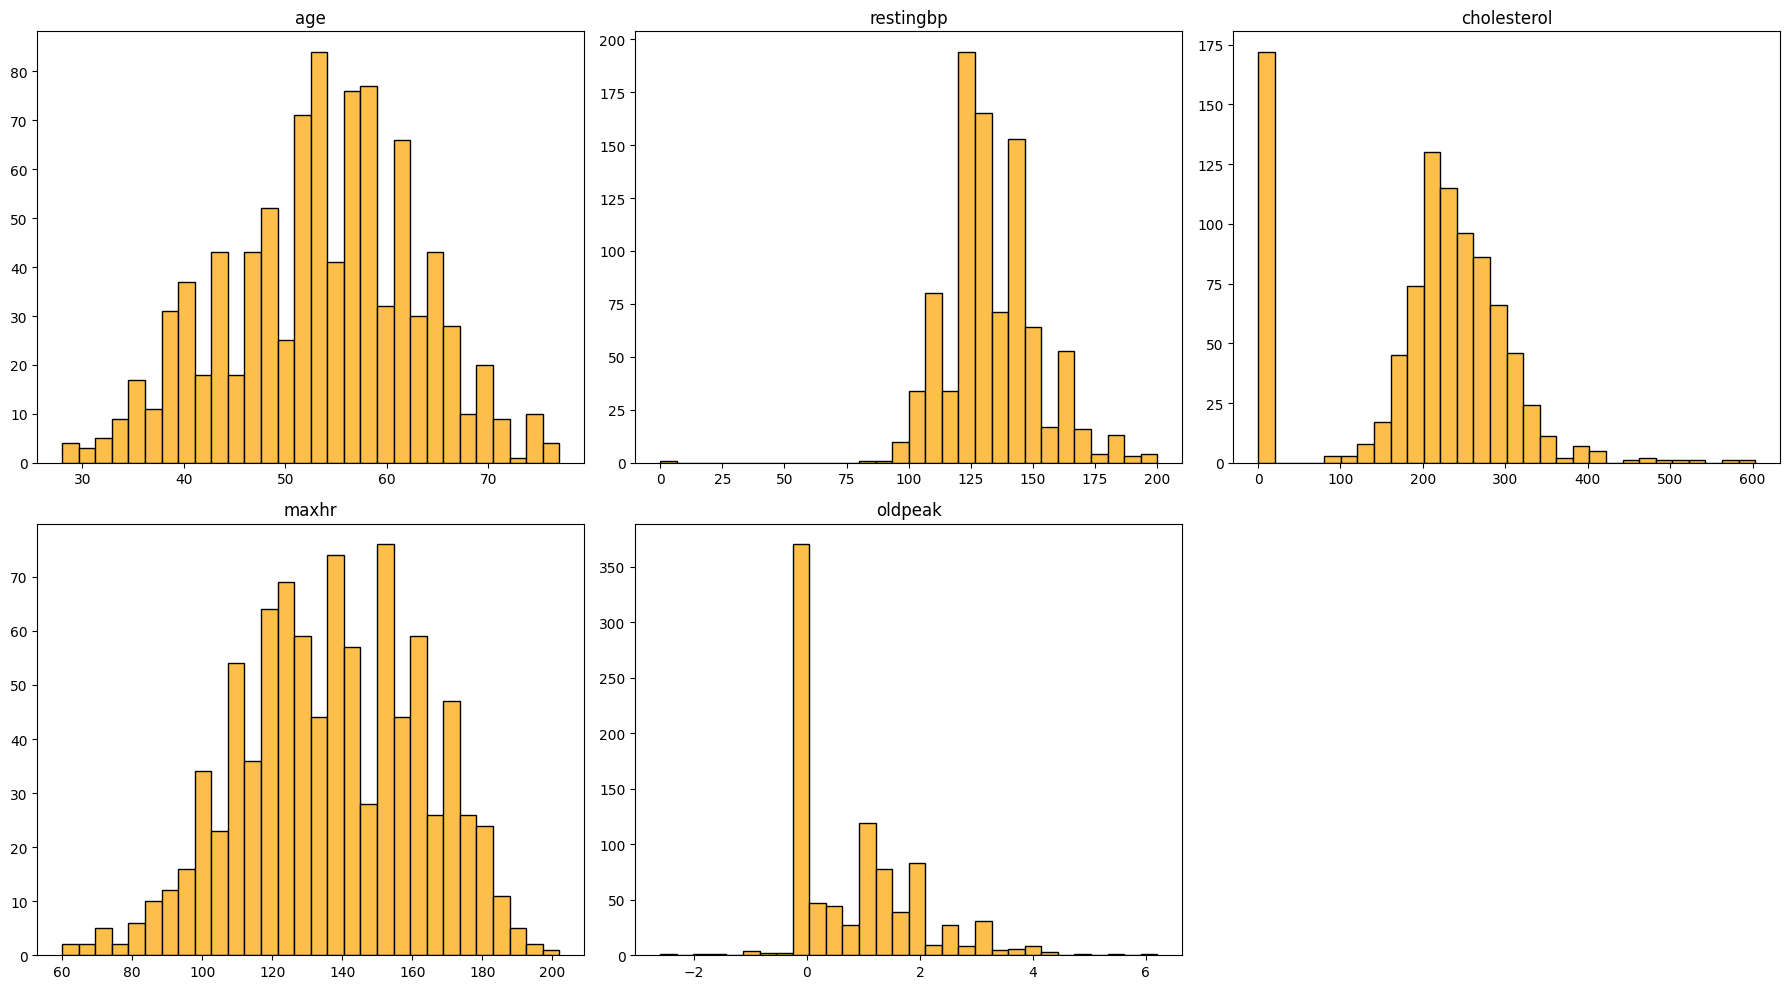

In [12]:
viz.distribution_plot(num_cont,2,3)

- The histograms for `age` and `maxhr` show a normal distribution with negative kurtosis, since the tails are not well-deffined.
- `oldpeak` histogram show a positive skewed distribution.
- We can spot some data inconsistencies or missing data errors in the `restingbp` and `cholesterol` histograms. There are some 0 values, for `cholesterol` is more evident, however `restingbp` and `cholesterol` levels cannot be 0. For that we need to fix the data replacing the 0 values with the median values for each column.
- This change will mainly impact to `cholesterol` since a big quantity of values are set to 0

In [13]:
# Fixing data errors for restingbp and  cholesterol columns
# Replace 0 with the median value of the restingbp and cholesterol columns
median_cholesterol = hd_df['cholesterol'].replace(0, np.nan).median() # Calculate the mean without the 0 values
hd_df['cholesterol'] = hd_df['cholesterol'].replace(0, median_cholesterol) # Replace 0 with the mean

median_restingbp = hd_df['restingbp'].replace(0, np.nan).median()
hd_df['restingbp'] = hd_df['restingbp'].replace(0, median_restingbp)

Calculate Descriptive Statistics again:

In [14]:
# Create a new dataframe with continuous data for the descriptive statistics
num_cont = hd_df.loc[:, hd_df.nunique() > 15]

# Descriptive statistics
num_cont.describe().round(2).T 

,count,mean,std,min,25%,50%,75%,max
age,918.0,53.51,9.43,28.0,47.0,54.0,60.0,77.0
restingbp,918.0,132.54,17.99,80.0,120.0,130.0,140.0,200.0
cholesterol,918.0,243.20,53.40,85.0,214.0,237.0,267.0,603.0
maxhr,918.0,136.81,25.46,60.0,120.0,138.0,156.0,202.0
oldpeak,918.0,0.89,1.07,-2.6,0.0,0.6,1.5,6.2


- Notice that std for `cholesterol` has decreased considerably

Let's see the distributions after handling data errors:

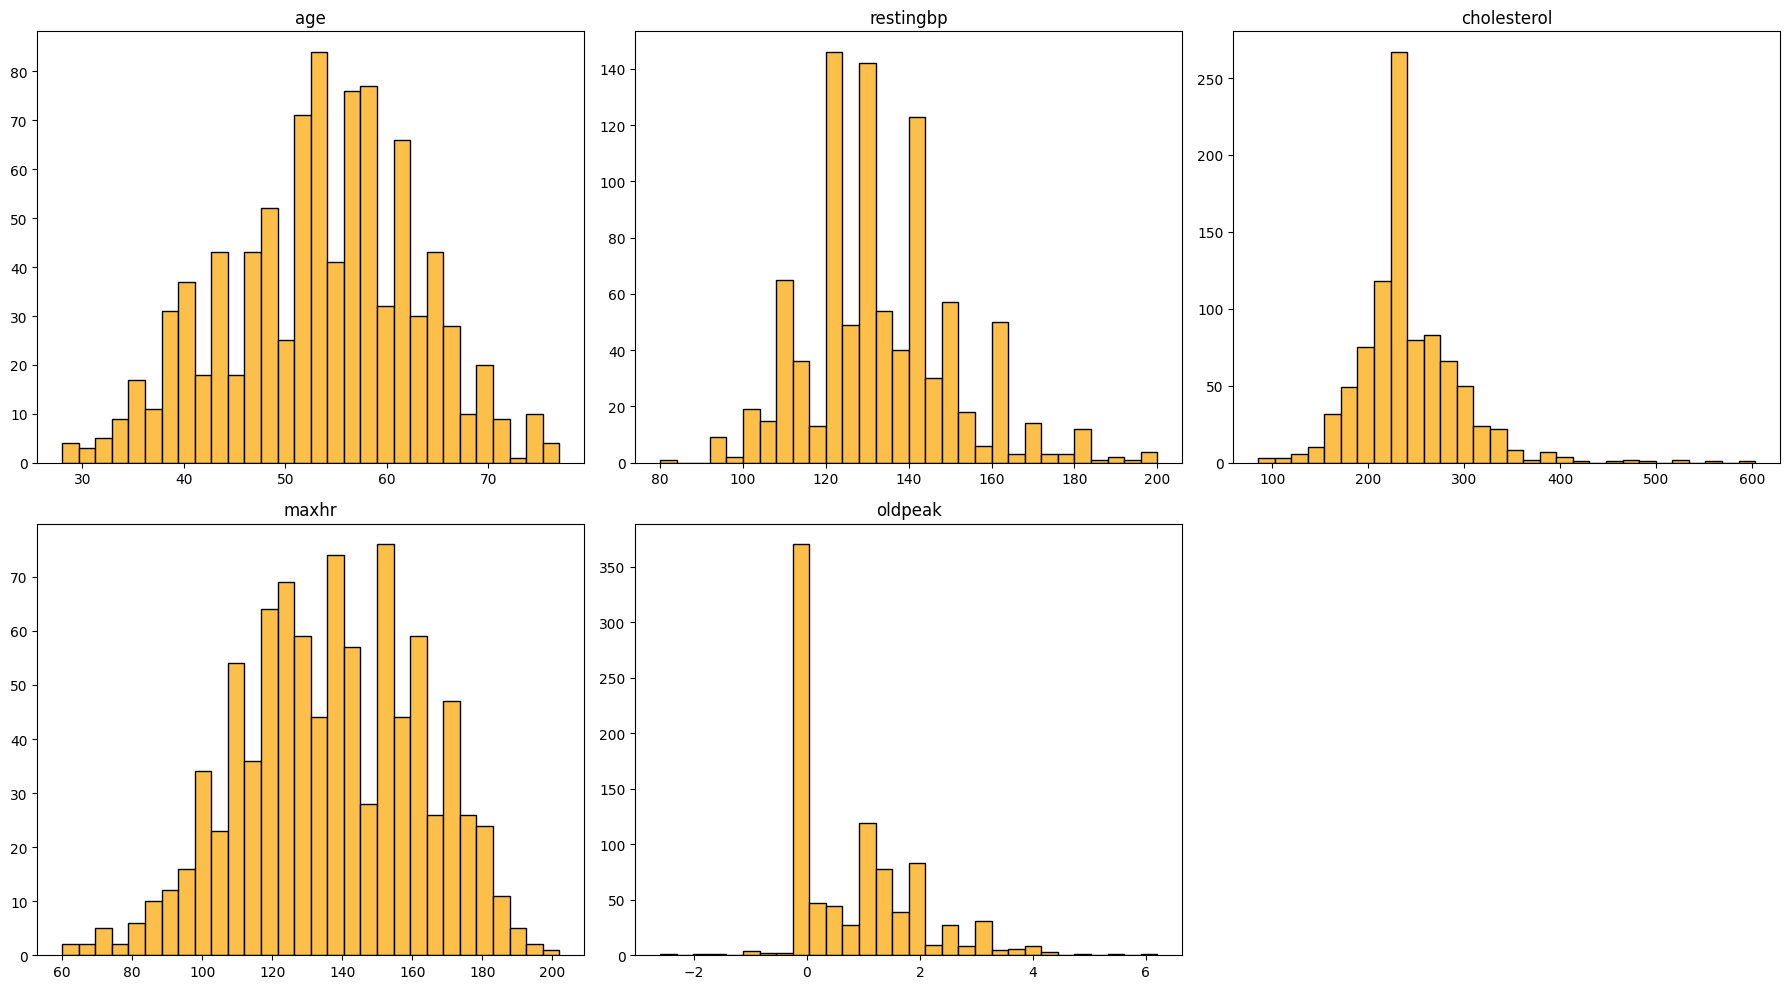

In [15]:
viz.distribution_plot(num_cont,2,3)

- `restingbp` histogram doesn't show negative skewness anymore. Now it looks more like a normal distribution.
- `cholesterol` histogram appear to be right skewed.

<h3 style="color: #f4e287;">Outliers </h3>

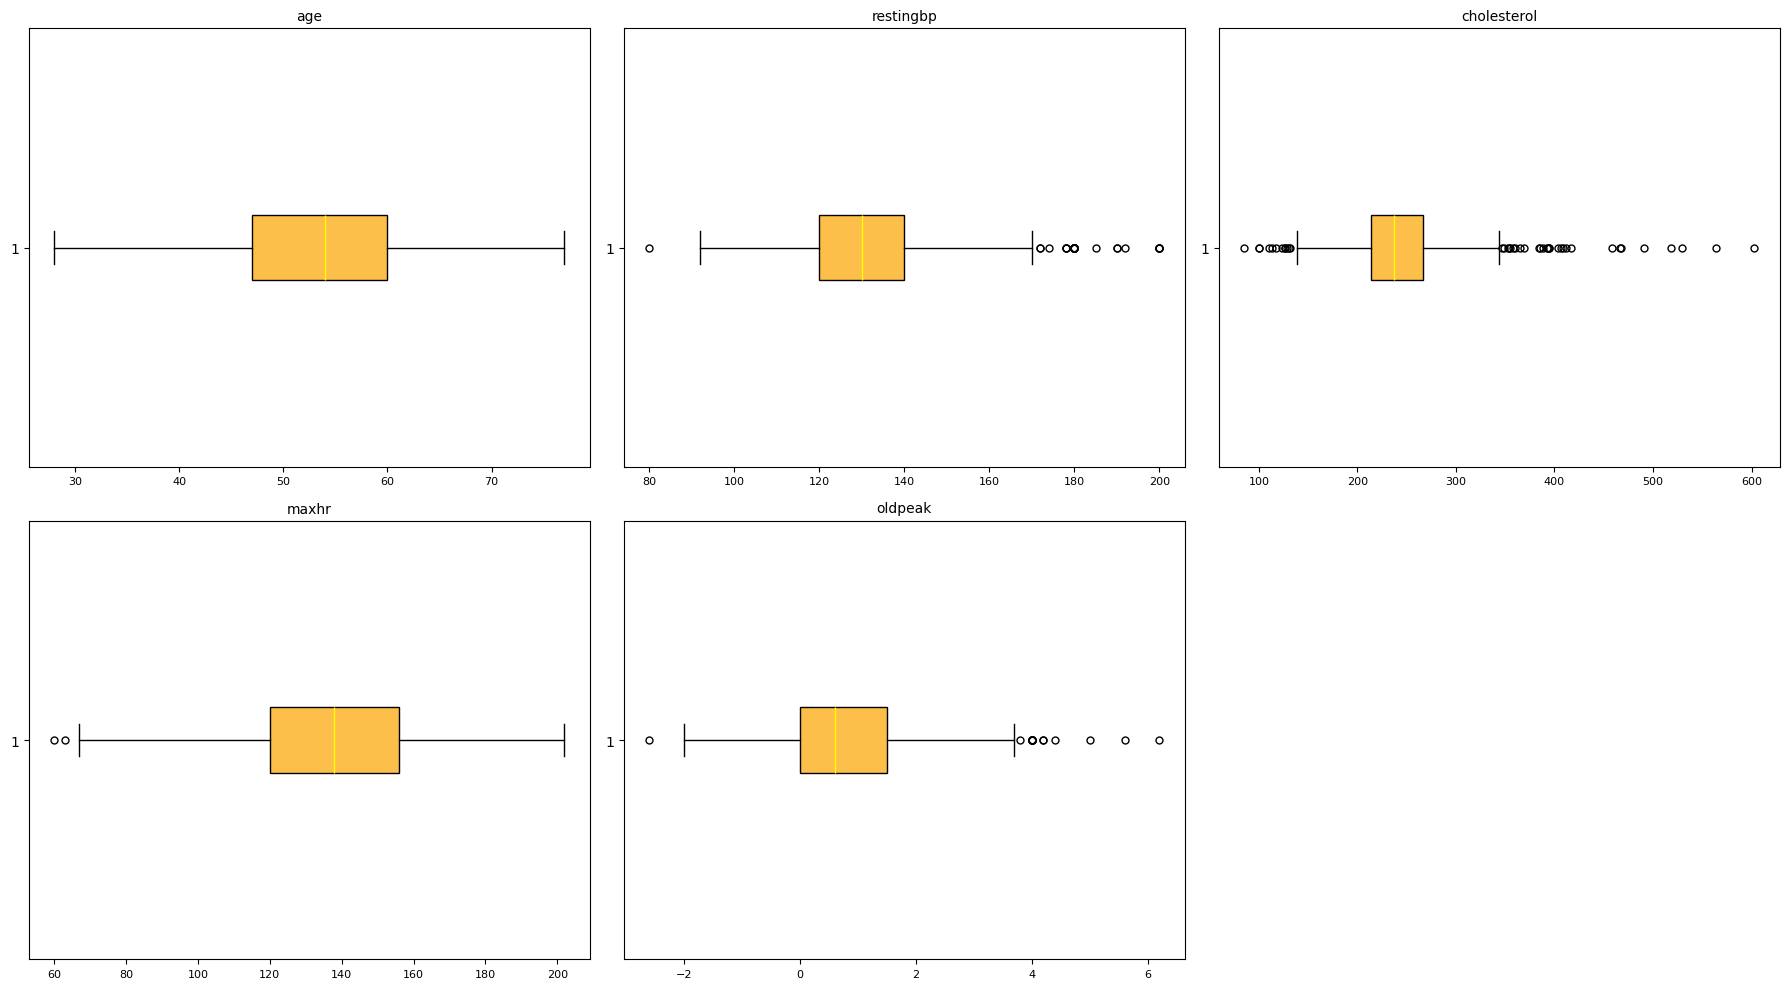

In [16]:
viz.outliers_distribution(num_cont,2,3)

- `age` and `maxhr` show long whiskers, but little outliers.
- `chelesterol` on the other hand shows outliers on both sides of the box plot

<h3 style="color: #f4e287;">Correlations </h3>

In [17]:
# Correlation with the target
hd_df.corr()["heartdisease"].sort_values(ascending=True)

st_slope_Up         -0.622164
chestpaintype_ATA   -0.401924
maxhr               -0.400421
sex                 -0.305445
chestpaintype_NAP   -0.212964
restingecg_Normal   -0.091580
chestpaintype_TA    -0.054790
restingecg_LVH       0.010670
cholesterol          0.076114
restingecg_ST        0.102527
restingbp            0.117798
st_slope_Down        0.122527
fastingbs            0.267291
age                  0.282039
oldpeak              0.403951
exerciseangina       0.494282
chestpaintype_ASY    0.516716
st_slope_Flat        0.554134
heartdisease         1.000000
Name: heartdisease, dtype: float64

<h3 style="color: #f4e287;">Dealing with Multicollinearity </h3>

In [18]:
# Move target to the last column for better visualization
target = hd_df.pop("heartdisease")
hd_df["heartdisease"] = target

In [19]:
# Create Correlation Matrix
num_corr = hd_df.corr().round(2)

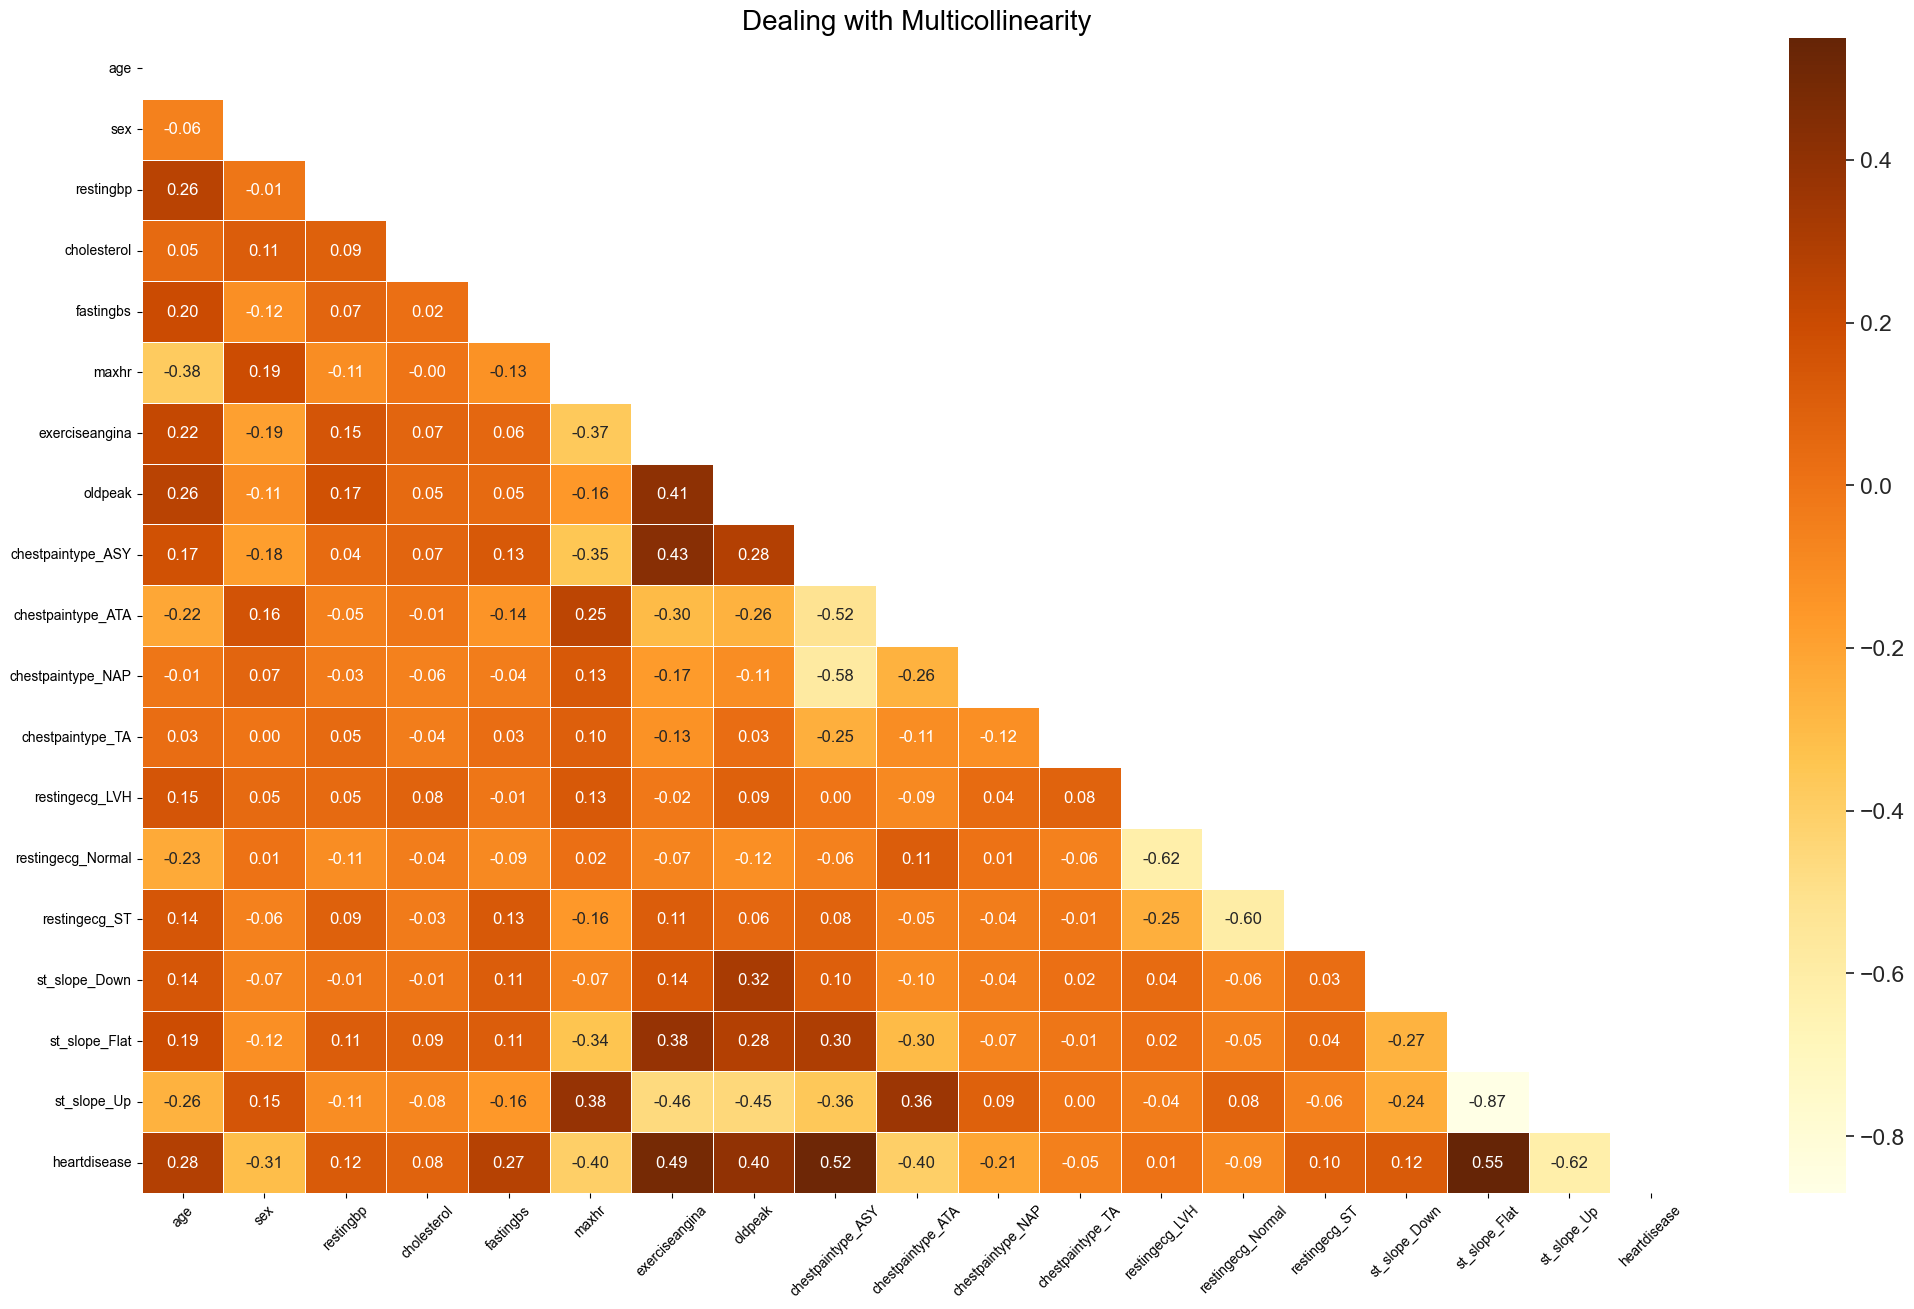

In [20]:
# Correlation Matrix-Heatmap Plot
viz.multicollinearity_heatmap(num_corr)

Dealing with multicolliinearity: no strong multicollinearity shown in the heatmap.

<h3 style="color: #f4e287;">Imbalance data </h3>

In [21]:
hd_df["heartdisease"].value_counts()

heartdisease
1    508
0    410
Name: count, dtype: int64

In [22]:
hd_df["heartdisease_label"] = hd_df["heartdisease"].map({0: "Normal", 1: "Heart Disease"})

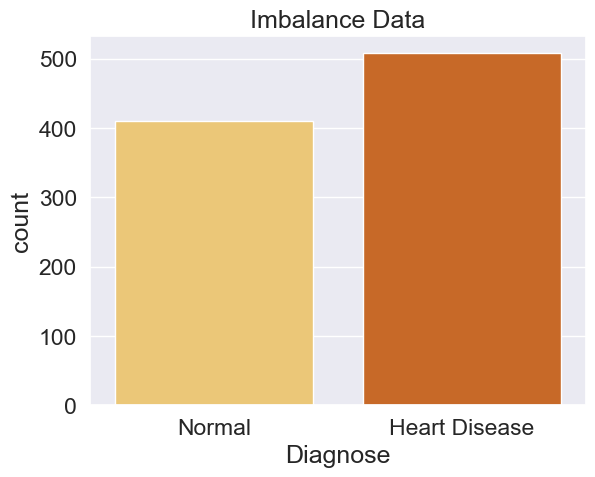

In [23]:
viz.imbalance_data(hd_df, "heartdisease_label")

In [24]:
hd_df = hd_df.drop("heartdisease_label", axis=1)

We need to create **synthetic data** to balance our target.

<h2 style="color: #75aadb;">05 | Modeling: Classification</h2>

<h3 style="color: #f4e287;">X-y Split </h3>

In [25]:
# X and y Split
X = hd_df.drop("heartdisease", axis=1)
y = hd_df["heartdisease"]

<h3 style="color: #f4e287;">Train-Test Split </h3>

In [26]:
# Split the data into train and test sets with a test size of 0.1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

<h3 style="color: #f4e287;">Data Preprocessing: Feature Scaling </h3>

In [27]:
# Define continuous columns and binary columns
continuous_columns = ['age', 'restingbp', 'cholesterol', 'maxhr', 'oldpeak']
binary_columns = ['sex',
                  'exerciseangina', 
                  'chestpaintype_ASY',
                  'chestpaintype_ATA', 
                  'chestpaintype_NAP', 
                  'chestpaintype_TA',
                  'restingecg_LVH',
                  'restingecg_Normal',
                  'restingecg_ST',
                  'st_slope_Down',
                  'st_slope_Flat',
                  'st_slope_Up']

In [28]:
# Create ColumnTransformer to apply StandardScaler just to continuous variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_columns),   # Scale continuous variables
        ('bin', 'passthrough', binary_columns)            # Leave binary variables as they are
    ])

# Create a SMOTE object for oversampling
smote = SMOTE(sampling_strategy='minority')

<h3 style="color: #f4e287;">Selecting the Model </h3>

I will compare different models to see which one fits better to the dataset:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Support Vector Machine (SVM)

In [29]:
# Define the models you want to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC()
}

# Evaluate the models performance using cross-validation
cm.model_evaluation(models, preprocessor, smote, X_train, y_train)


📈 Evaluating with 3-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8469 ± 0.0080
	Decision Tree Average Accuracy: 0.7808 ± 0.0130
	Random Forest Average Accuracy: 0.8579 ± 0.0133
	XGBoost Average Accuracy: 0.8535 ± 0.0163
	SVM Average Accuracy: 0.8601 ± 0.0040

📈 Evaluating with 5-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8524 ± 0.0170
	Decision Tree Average Accuracy: 0.7874 ± 0.0191
	Random Forest Average Accuracy: 0.8568 ± 0.0142
	XGBoost Average Accuracy: 0.8602 ± 0.0324
	SVM Average Accuracy: 0.8723 ± 0.0272

📈 Evaluating with 8-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8557 ± 0.0174
	Decision Tree Average Accuracy: 0.7952 ± 0.0327
	Random Forest Average Accuracy: 0.8679 ± 0.0266
	XGBoost Average Accuracy: 0.8635 ± 0.0330
	SVM Average Accuracy: 0.8656 ± 0.0228

📈 Evaluating with 10-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8592 ± 0.0322
	Decision Tree Average Accuracy: 0.7942 ± 0.0492
	Random Fo

- The best model are **SVM** and **Random Forest**
- The best number folds of cross-validation is 5

<h3 style="color: #f4e287;">Model Validation & Metrics</h3>

### Random Forest

In [30]:
# Check with the baseline model which is the best test size
random_state = 42
model_random = RandomForestClassifier()
cm.classification_metrics(X, y, hd_df, random_state, model_random)

10.0% test size
100% of our data: 918.
90.0% for training data: 826.
10.0% for test data: 92.

20.0% test size
100% of our data: 918.
80.0% for training data: 734.
20.0% for test data: 184.

30.0% test size
100% of our data: 918.
70.0% for training data: 642.
30.0% for test data: 276.

40.0% test size
100% of our data: 918.
60.0% for training data: 550.
40.0% for test data: 368.



,test_size,accuracy,precision,recall,f1
0,10.0%,0.902,0.909,0.926,0.917
1,20.0%,0.870,0.903,0.869,0.886
2,30.0%,0.866,0.910,0.860,0.884
3,40.0%,0.851,0.923,0.819,0.868


##### Best Test Size: 10%

In [ ]:
# Split the data into train and test sets with a test size of 0.1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [31]:
# Create a Random Forest classifier
model_random = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Create a pipeline for preprocessing 
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing 
    ('classifier', model_random)  # Random Forest classifier
])

# Perform cross-validation manually, applying SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Perform cross-validation on resampled training data
cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Average Accuracy from CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Average Accuracy from CV: 0.8646 ± 0.0313


In [33]:
# Now fit the model on the entire resampled training set (using the pipeline)
pipeline.fit(X_train_resampled, y_train_resampled)

# After training, make predictions on the test set
y_pred_random = pipeline.predict(X_test)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_random))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        38
           1       0.93      0.93      0.93        54

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92



<Figure size 800x600 with 0 Axes>

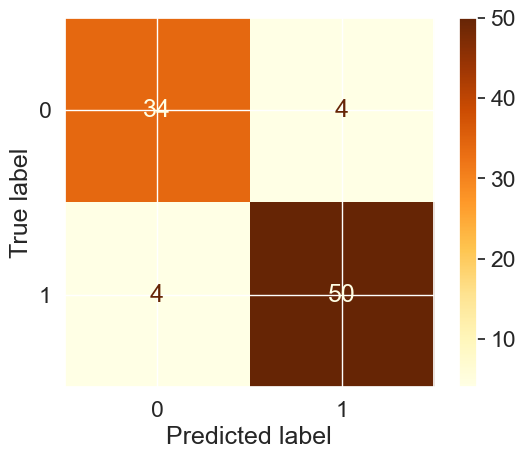

In [ ]:
# Plot confusion matrix
viz.confusion_matrix_plot(y_test, y_pred_random)

- Equal Type I and Type II errors
- High prediction

### SVC Model

In [35]:
# Check with the baseline model which is the best test size
model_SVC = SVC()
cm.classification_metrics(X, y, hd_df, random_state, model_SVC)

10.0% test size
100% of our data: 918.
90.0% for training data: 826.
10.0% for test data: 92.

20.0% test size
100% of our data: 918.
80.0% for training data: 734.
20.0% for test data: 184.

30.0% test size
100% of our data: 918.
70.0% for training data: 642.
30.0% for test data: 276.

40.0% test size
100% of our data: 918.
60.0% for training data: 550.
40.0% for test data: 368.



,test_size,accuracy,precision,recall,f1
0,10.0%,0.674,0.731,0.704,0.717
1,20.0%,0.668,0.740,0.664,0.700
2,30.0%,0.710,0.762,0.744,0.753
3,40.0%,0.693,0.762,0.710,0.735


##### Best Test Size: 30%

In [36]:
# Split the data into train and test sets with a test size of 0.3
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
# Create a Random Forest classifier
model_svc = SVC()

In [38]:
# Create a pipeline for preprocessing 
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing 
    ('classifier', model_svc)  # Random Forest classifier
])

# Perform cross-validation manually, applying SMOTE only to the training data
X_train_resampled_svc, y_train_resampled_svc = smote.fit_resample(X_train_svc, y_train_svc)

# Perform cross-validation on resampled training data
cv_scores_svc = cross_val_score(pipeline_svc, X_train_resampled_svc, y_train_resampled_svc, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Average Accuracy from CV: {np.mean(cv_scores_svc):.4f} ± {np.std(cv_scores_svc):.4f}")

Average Accuracy from CV: 0.8663 ± 0.0282


In [39]:
# Now fit the model on the entire resampled training set (using the pipeline)
pipeline_svc.fit(X_train_resampled_svc, y_train_resampled_svc)

# After training, make predictions on the test set
y_pred_svc = pipeline_svc.predict(X_test_svc)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test_svc, y_pred_svc))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       112
           1       0.90      0.85      0.87       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276



<Figure size 800x600 with 0 Axes>

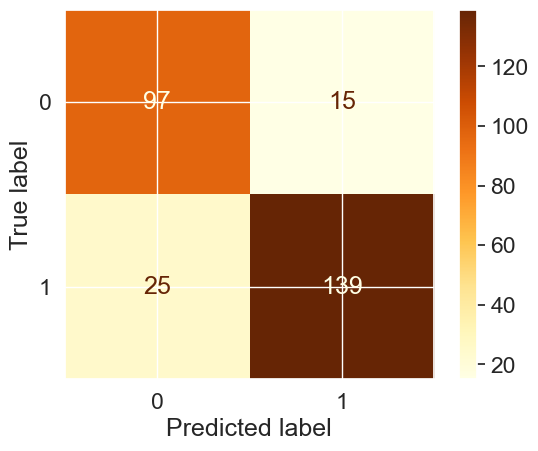

In [40]:
# Plot confusion matrix
viz.confusion_matrix_plot(y_test_svc, y_pred_svc)

- High Type II errors, which are the ones we want to avoid when working in healthcare 
- High prediction for Heart disease

<h2 style="color: #75aadb;">06 | Improving the Model</h2>

<h3 style="color: #f4e287;">Hyperparameter Tuning </h3>

<h2 style="color: #75aadb;">07 | Reporting</h2>